# 전국 민간 아파트 분양가격 분석하기

# import

In [1]:
# 사용할 패키지를 import합니다
import sys
print('python', sys.version)

import numpy as np
print('numpy', np.__version__)

import pandas as pd
print('pandas', pd.__version__)

import matplotlib as mpl
print('matplotlib', mpl.__version__)

import matplotlib.pyplot as plt

import seaborn as sns
print('pandas', sns.__version__)

# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# # 경고 메시지는 출력되지 않게 합니다.
# import warnings
# warnings.filterwarnings("ignore")

python 3.10.16 (main, Dec  3 2024, 17:27:57) [Clang 16.0.0 (clang-1600.0.26.4)]
numpy 1.26.4
pandas 2.2.3
matplotlib 3.10.0
pandas 0.13.2


# df_2023 전처리 코드

In [4]:
####### df_2023 전처리하기
df_2023 = pd.read_csv("data/전국평균 분양가격 (2015년10월~2023년6월).csv", encoding="cp949") #default: sep=','
df_2023.head()
df_2023.info()

### ==> 1) '분양가격(제곱미터)'column: nan(결측치) 제거
df_2023_nn=df_2023.loc[df_2023['분양가격(제곱미터)'].notnull()]

# ### ==> 2) '분양가격(제곱미터)'column: 숫자로 구성된 문자 -> float형 | 숫자가 아닌 문자 -> nan으로 변경 후 행 제거
df_2023_ft=df_2023_nn.copy()
df_2023_ft['분양가격(제곱미터)']=pd.to_numeric(df_2023_ft['분양가격(제곱미터)'], errors='coerce')
df_2023_ft=df_2023_ft.loc[df_2023_ft['분양가격(제곱미터)'].notnull()]

### ==> 3) '분양가격(제곱미터)'을  '분양가격'으로 변환하기
df_2023_ft["분양가격"]=df_2023_ft['분양가격(제곱미터)'] * 3.3
df_prep=df_2023_ft.drop(columns=['분양가격(제곱미터)'])

### ==> 4) '규모구분'을 '전용면적'으로 변환하기
def parse_area_only(x):
    x2=x.replace("모든면적", "전체").replace("전용면적", "").replace("제곱미터", "").replace("60이하", "~60")
    x3=x2.replace("초과", "~").replace("이하", "").replace(" ", "")
    return x3
    
df_prep["전용면적"] = df_prep["규모구분"].map(parse_area_only)
df_prep=df_prep.drop(columns=['규모구분'], errors='ignore') # '규모구분' column이 없는 경우 error raise 방지

## ==> 5) reset_index 후 전처리한 데이터 확인하기
df_prep=df_prep.reset_index(drop=True)

df_prep.head()
df_prep.info()

,지역명,규모구분,연도,월,분양가격(제곱미터)
0,서울,모든면적,2015,10,5841
1,서울,전용면적 60제곱미터이하,2015,10,5652
2,서울,전용면적 60제곱미터초과 85제곱미터이하,2015,10,5882
3,서울,전용면적 85제곱미터초과 102제곱미터이하,2015,10,5721
4,서울,전용면적 102제곱미터초과,2015,10,5879


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   지역명         7905 non-null   object
 1   규모구분        7905 non-null   object
 2   연도          7905 non-null   int64 
 3   월           7905 non-null   int64 
 4   분양가격(제곱미터)  7358 non-null   object
dtypes: int64(2), object(3)
memory usage: 308.9+ KB


,지역명,연도,월,분양가격,전용면적
0,서울,2015,10,19275.3,전체
1,서울,2015,10,18651.6,~60
2,서울,2015,10,19410.6,60~85
3,서울,2015,10,18879.3,85~102
4,서울,2015,10,19400.7,102~


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7322 entries, 0 to 7321
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   지역명     7322 non-null   object 
 1   연도      7322 non-null   int64  
 2   월       7322 non-null   int64  
 3   분양가격    7322 non-null   float64
 4   전용면적    7322 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 286.1+ KB


# ====== 이번주 수업내용 ======

## 전용면적 별 분양가격 평균 구하기


전용면적
102~      13152.676793
60~85     11895.030518
85~102    12750.729685
~60       11859.274417
전체        11923.028544
Name: 분양가격, dtype: float64

전용면적
~60       11859.274417
60~85     11895.030518
전체        11923.028544
85~102    12750.729685
102~      13152.676793
Name: 분양가격, dtype: float64

## 연도 별 분양가격 평균, 중앙값 구하기


연도
2015     8302.80
2016     8817.60
2017     9365.40
2018     9741.60
2019    11203.50
2020    12323.85
2021    12731.40
2022    13823.70
2023    15374.70
Name: 분양가격, dtype: float64

연도
2015     9202.735802
2016     9683.025000
2017    10372.928923
2018    10978.938411
2019    12188.293092
2020    13039.422449
2021    13636.022540
2022    14942.504494
2023    16277.103106
Name: 분양가격, dtype: float64

## 2015년 분양가격 분포 확인하기
## 전용면적 별 연도 별 분양가격 평균 구하기


전용면적    연도  
102~    2015     9837.226667
        2016    10388.728272
        2017    11311.244162
        2018    11445.574576
        2019    13331.520968
        2020    14068.432919
        2021    14380.755172
        2022    15990.638265
        2023    17272.686316
60~85   2015     8891.817647
        2016     9295.986765
        2017     9840.438235
        2018    10650.611823
        2019    11677.201531
        2020    12327.480000
        2021    13644.416176
        2022    14695.175000
        2023    15673.317647
85~102  2015     9518.506250
        2016    10122.355435
        2017    10573.447977
        2018    11441.707895
        2019    12980.676923
        2020    14759.608696
        2021    13532.067470
        2022    15523.450877
        2023    16378.463415
~60     2015     8951.525000
        2016     9398.876119
        2017    10271.375635
        2018    10844.409783
        2019    11506.803371
        2020    12400.844211
        2021    12983.757868
 

분양가격
전용면적   연도                
102~   2015   9837.226667
       2016  10388.728272
       2017  11311.244162
       2018  11445.574576
       2019  13331.520968
       2020  14068.432919
       2021  14380.755172
       2022  15990.638265
       2023  17272.686316
60~85  2015   8891.817647
       2016   9295.986765
       2017   9840.438235
       2018  10650.611823
       2019  11677.201531
       2020  12327.480000
       2021  13644.416176
       2022  14695.175000
       2023  15673.317647
85~102 2015   9518.506250
       2016  10122.355435
       2017  10573.447977
       2018  11441.707895
       2019  12980.676923
       2020  14759.608696
       2021  13532.067470
       2022  15523.450877
       2023  16378.463415
~60    2015   8951.525000
       2016   9398.876119
       2017  10271.375635
       2018  10844.409783
       2019  11506.803371
       2020  12400.844211
       2021  12983.757868
       2022  13948.000000
       2023  16230.661765
전체     2015   8893.047059
       2016   9293.042647
       2017   9927.322059
       2018  10675.825123
       2019  11602.715816
       2020  12317.716667
       2021  13706.889706
       2022  14690.338235
       2023  15918.585294

,전용면적,연도,분양가격
0,102~,2015,9837.226667
1,102~,2016,10388.728272
2,102~,2017,11311.244162
3,102~,2018,11445.574576
4,102~,2019,13331.520968
5,102~,2020,14068.432919
6,102~,2021,14380.755172
7,102~,2022,15990.638265
8,102~,2023,17272.686316
9,60~85,2015,8891.817647


## 전용면적 별 분양가격이 8000 이상인 분양가격 평균 구하기
# 방법1 (groupby & apply)


전용면적
102~      13641.163073
60~85     12875.832737
85~102    13202.763644
~60       12786.739888
전체        12901.118668
Name: 분양가격, dtype: float64

# 방법2 (loc & groupby)


전용면적
102~      13641.163073
60~85     12875.832737
85~102    13202.763644
~60       12786.739888
전체        12901.118668
Name: 분양가격, dtype: float64

## 지역내의 분양가격 불균형 여부를 파악하기 위해
# 지역별로 평균(a1)대비 최대분양가격(m1)과 최소 분양가격의 차이(n1)를 구하시오: (m1-n1)/a1


지역명
세종    0.456527
충북    0.599310
전북    0.682830
경북    0.714563
전남    0.743640
경기    0.853218
충남    0.860557
강원    0.888407
경남    0.894296
대전    0.948174
대구    0.955084
부산    0.981250
서울    1.100706
인천    1.115499
제주    1.377654
광주    1.451115
울산    1.454671
Name: 분양가격, dtype: float64

# 지역별로 평균(a1)대비 상위 top10 분양가격의 평균(m1)과 하위 top10 분양가격의 평균(n1)의 차이를 구하시오 : (m1-n1)/a1


지역명
세종    0.448758
충북    0.558098
전북    0.615403
전남    0.673284
경북    0.680569
경기    0.763341
충남    0.770458
인천    0.784940
강원    0.812415
대전    0.824474
경남    0.826209
대구    0.831521
부산    0.843288
서울    0.915880
광주    1.020317
울산    1.177216
제주    1.307669
Name: 분양가격, dtype: float64

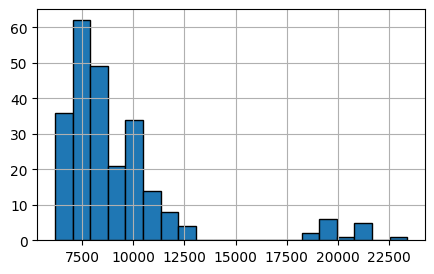

In [5]:
print('==================================')
print('## 전용면적 별 분양가격 평균 구하기')
df_prep.groupby(["전용면적"])["분양가격"].mean()
df_prep.groupby(["전용면적"])["분양가격"].mean().sort_values()

print('==================================')
print('## 연도 별 분양가격 평균, 중앙값 구하기')
df_prep.groupby(['연도'])["분양가격"].median()
df_prep.groupby(['연도'])["분양가격"].mean()

print('==================================')
print('## 2015년 분양가격 분포 확인하기')
fig=plt.figure(figsize=(5,3))
ax1=fig.subplots()
_=df_prep.loc[df_prep['연도']==2015,'분양가격'].hist(bins=20, edgecolor='k', ax=ax1)

print('==================================')
print('## 전용면적 별 연도 별 분양가격 평균 구하기')
df_prep.groupby(["전용면적",'연도'])["분양가격"].mean() # series
df_prep.groupby(["전용면적",'연도'])["분양가격"].mean().to_frame() # dataframe(multi-index)
df_prep.groupby(["전용면적",'연도'])["분양가격"].mean().to_frame().reset_index()

print('==================================')
print('## 전용면적 별 분양가격이 8000 이상인 분양가격 평균 구하기')
print('# 방법1 (groupby & apply)')
df2=df_prep.groupby('전용면적')['분양가격'].apply(lambda x: np.mean(x.loc[x>8000]))
df2

print('# 방법2 (loc & groupby)')
df3=df_prep.loc[df_prep['분양가격']>8000].groupby('전용면적')['분양가격'].mean()
df3

print('==================================')
print('## 지역내의 분양가격 불균형 여부를 파악하기 위해')
print('# 지역별로 평균(a1)대비 최대분양가격(m1)과 최소 분양가격의 차이(n1)를 구하시오: (m1-n1)/a1')

sr2=df_prep.groupby('지역명')['분양가격'].apply(lambda sr1: (sr1.max()-sr1.min())/sr1.mean()).sort_values()
sr2

print('# 지역별로 평균(a1)대비 상위 top10 분양가격의 평균(m1)과 하위 top10 분양가격의 평균(n1)의 차이를 구하시오 : (m1-n1)/a1')

def check_bias(sr1):
    sr2=sr1.sort_values(ascending=False)
    t1=sr2.head(10).mean()
    b1=sr2.tail(10).mean()
    m1=sr1.mean()
    return (t1-b1)/m1

sr3=df_prep.groupby('지역명')['분양가격'].apply(check_bias).sort_values()
sr3

# groupby로 데이터 집계하기 (groupning item 1개)
## groupby 설명

In [34]:
###########################
######### ppt 참고 ########
##########################

In [11]:
df = pd.read_table("data/pandas_data3.txt", index_col=0)
df.info()
df.head()

for key, group in df.groupby('gender'):
    print(key)
    print(group['mid'].mean())
    
df.groupby('gender')['mid'].mean()
    



<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, kim2 to lee4
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   gender  30 non-null     object
 1   year    30 non-null     int64 
 2   mid     30 non-null     int64 
 3   final   30 non-null     int64 
 4   att     30 non-null     int64 
 5   proj    30 non-null     int64 
dtypes: int64(5), object(1)
memory usage: 1.6+ KB


,gender,year,mid,final,att,proj
name,,,,,,
kim2,F,1,12,36,5,75
kim3,M,2,17,20,5,96
kim6,M,2,28,20,4,83
kim7,M,2,20,44,6,82
kim8,F,1,20,24,8,88


F
21.1
M
22.3


gender
F    21.1
M    22.3
Name: mid, dtype: float64

In [17]:
df.groupby(['gender', 'year'])['mid'].mean() # Series
df.groupby(['gender', 'year'])['mid'].mean().index # MultiIndex

gender  year
F       1       21.250000
        2       17.500000
        3       22.000000
        4       23.000000
M       1       19.000000
        2       23.600000
        3       22.285714
        4       23.000000
Name: mid, dtype: float64

MultiIndex([('F', 1),
            ('F', 2),
            ('F', 3),
            ('F', 4),
            ('M', 1),
            ('M', 2),
            ('M', 3),
            ('M', 4)],
           names=['gender', 'year'])

In [18]:
# MultiIndex 만들어보기
df = pd.DataFrame(np.random.randn(4,2), index=[['a', 'a', 'b', 'b'], ['1', '2', '1', '2']])
df
df.index
df.index.names = ['alpha', 'num']
df



0         1
a 1 -0.998564 -0.603048
  2  0.285719 -1.737200
b 1  0.286680  1.140868
  2  0.993297 -0.086958

MultiIndex([('a', '1'),
            ('a', '2'),
            ('b', '1'),
            ('b', '2')],
           )

0         1
alpha num                    
a     1   -0.998564 -0.603048
      2    0.285719 -1.737200
b     1    0.286680  1.140868
      2    0.993297 -0.086958

## groupby 예제

In [13]:
d1 = pd.read_csv("data/pandas_data3.txt", encoding="cp949", sep='\t')
d1 = d1.head(10)
d1
d1.groupby('gender')['mid'].sum()

#############
df_prep
df_prep.groupby(['지역명'])['분양가격'].mean().sort_values()

,name,gender,year,mid,final,att,proj
0,kim2,F,1,12,36,5,75
1,kim3,M,2,17,20,5,96
2,kim6,M,2,28,20,4,83
3,kim7,M,2,20,44,6,82
4,kim8,F,1,20,24,8,88
5,kim9,M,3,23,45,10,92
6,kim10,M,3,16,47,5,83
7,lee5,M,3,21,35,5,92
8,lee9,M,3,20,36,5,87
9,lee10,F,4,28,41,9,87


gender
F     60
M    145
Name: mid, dtype: int64

,지역명,연도,월,분양가격,전용면적
0,서울,2015,10,19275.3,전체
1,서울,2015,10,18651.6,~60
2,서울,2015,10,19410.6,60~85
3,서울,2015,10,18879.3,85~102
4,서울,2015,10,19400.7,102~
...,...,...,...,...,...
7317,제주,2023,6,24175.8,전체
7318,제주,2023,6,24357.3,~60
7319,제주,2023,6,23377.2,60~85
7320,제주,2023,6,21908.7,85~102


지역명
충북     8391.643413
전북     8486.440347
전남     8728.814634
강원     9297.425828
충남     9303.040359
경북     9707.467720
경남    10405.949342
세종    10618.640409
대전    11471.316522
광주    12075.542188
울산    13196.176347
부산    13717.907559
인천    13794.637093
대구    13903.696053
경기    14561.927742
제주    14815.404580
서울    26305.108753
Name: 분양가격, dtype: float64

## groupby 메커니즘 확인하기

In [9]:
for key, df in df_prep.groupby(['지역명']):
    key
    df.head()
    break
    
for key, df in df_prep.groupby(['지역명'])['분양가격']:
    key
    df.head()
    break

('강원',)

,지역명,연도,월,분양가격,전용면적
42,강원,2015,10,7151.1,모든면적
43,강원,2015,10,7543.8,~60
44,강원,2015,10,7299.6,60~85
45,강원,2015,10,6801.3,85~102
46,강원,2015,10,7164.3,102~


('강원',)

42    7151.1
43    7543.8
44    7299.6
45    6801.3
46    7164.3
Name: 분양가격, dtype: float64

## groupby 예제2

In [14]:
# 전용면적 별 분양가격 평균 구하기
df_prep.groupby(["전용면적"])["분양가격"].mean()
df_prep.groupby(["전용면적"])["분양가격"].mean().sort_values()

전용면적
102~      13152.676793
60~85     11895.030518
85~102    12750.729685
~60       11859.274417
모든면적      11923.028544
Name: 분양가격, dtype: float64

전용면적
~60       11859.274417
60~85     11895.030518
모든면적      11923.028544
85~102    12750.729685
102~      13152.676793
Name: 분양가격, dtype: float64

# groupby로 데이터 집계하기 (grouping item 2개)

In [15]:
df_prep.groupby(["전용면적",'연도'])["분양가격"].mean() # series
df_prep.groupby(["전용면적",'연도'])["분양가격"].mean().to_frame() # dataframe(multi-index)
df_prep.groupby(["전용면적",'연도'])["분양가격"].mean().to_frame().reset_index()

전용면적    연도  
102~    2015     9837.226667
        2016    10388.728272
        2017    11311.244162
        2018    11445.574576
        2019    13331.520968
        2020    14068.432919
        2021    14380.755172
        2022    15990.638265
        2023    17272.686316
60~85   2015     8891.817647
        2016     9295.986765
        2017     9840.438235
        2018    10650.611823
        2019    11677.201531
        2020    12327.480000
        2021    13644.416176
        2022    14695.175000
        2023    15673.317647
85~102  2015     9518.506250
        2016    10122.355435
        2017    10573.447977
        2018    11441.707895
        2019    12980.676923
        2020    14759.608696
        2021    13532.067470
        2022    15523.450877
        2023    16378.463415
~60     2015     8951.525000
        2016     9398.876119
        2017    10271.375635
        2018    10844.409783
        2019    11506.803371
        2020    12400.844211
        2021    12983.757868
 

분양가격
전용면적   연도                
102~   2015   9837.226667
       2016  10388.728272
       2017  11311.244162
       2018  11445.574576
       2019  13331.520968
       2020  14068.432919
       2021  14380.755172
       2022  15990.638265
       2023  17272.686316
60~85  2015   8891.817647
       2016   9295.986765
       2017   9840.438235
       2018  10650.611823
       2019  11677.201531
       2020  12327.480000
       2021  13644.416176
       2022  14695.175000
       2023  15673.317647
85~102 2015   9518.506250
       2016  10122.355435
       2017  10573.447977
       2018  11441.707895
       2019  12980.676923
       2020  14759.608696
       2021  13532.067470
       2022  15523.450877
       2023  16378.463415
~60    2015   8951.525000
       2016   9398.876119
       2017  10271.375635
       2018  10844.409783
       2019  11506.803371
       2020  12400.844211
       2021  12983.757868
       2022  13948.000000
       2023  16230.661765
모든면적   2015   8893.047059
       2016   9293.042647
       2017   9927.322059
       2018  10675.825123
       2019  11602.715816
       2020  12317.716667
       2021  13706.889706
       2022  14690.338235
       2023  15918.585294

,전용면적,연도,분양가격
0,102~,2015,9837.226667
1,102~,2016,10388.728272
2,102~,2017,11311.244162
3,102~,2018,11445.574576
4,102~,2019,13331.520968
5,102~,2020,14068.432919
6,102~,2021,14380.755172
7,102~,2022,15990.638265
8,102~,2023,17272.686316
9,60~85,2015,8891.817647


## multi-index 다루기

In [16]:
sr1=pd.Series(list('abcd'), index=list('wert'))
sr1
sr1.loc[['e','t']]

w    a
e    b
r    c
t    d
dtype: object

e    b
t    d
dtype: object

In [26]:
df1=df_prep.groupby(["전용면적",'연도'])["분양가격"].mean().to_frame()
df1.head()
df1.loc[('102~',2017)] # NOT df1.loc[['102~',2015]]
df1.loc[('102~',2017)].iloc[0] # scalor 값 얻기
df1.loc[[('102~',2017),('85~102',2017)]]

분양가격
전용면적 연도                
102~ 2015   9837.226667
     2016  10388.728272
     2017  11311.244162
     2018  11445.574576
     2019  13331.520968

분양가격    11311.244162
Name: (102~, 2017), dtype: float64

11311.24416243655

,,분양가격
전용면적,연도,
102~,2017,11311.244162
85~102,2017,10573.447977


## <실습1>
* 1) 연도별 분양가격의 중앙값을 구하시오
* 2) 연도별 분양가격의 평균을 구하시오
* 3) 1),2) 결과가 차이나는 것을 확인할수 있도록 2015년 분양가격을 histogram을 그려보시오 (평균의 함정)

In [14]:
df_prep.head(1)

,지역명,연도,월,평당분양가격,전용면적
0,서울,2015,10,19275.3,전체


연도
2015     8302.80
2016     8817.60
2017     9365.40
2018     9741.60
2019    11203.50
2020    12323.85
2021    12731.40
2022    13823.70
2023    15374.70
Name: 분양가격, dtype: float64

연도
2015     9202.735802
2016     9683.025000
2017    10372.928923
2018    10978.938411
2019    12188.293092
2020    13039.422449
2021    13636.022540
2022    14942.504494
2023    16277.103106
Name: 분양가격, dtype: float64

<Axes: >

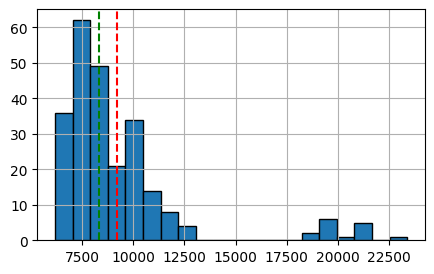

In [24]:
# 1)
## 코드작성 ##
df_prep.groupby(['연도'])["분양가격"].median()
# 2)
## 코드작성 ##
df_prep.groupby(['연도'])["분양가격"].mean()

# 3)
fig=plt.figure(figsize=(5,3))
ax1=fig.subplots()
## 코드작성 ##
df_prep.loc[df_prep['연도']==2015, '분양가격'].hist(bins=20, edgecolor='k', ax=ax1)
ax1.axvline(df_prep.loc[df_prep['연도']==2015, '분양가격'].mean(), color='r', linestyle='--')
ax1.axvline(df_prep.loc[df_prep['연도']==2015, '분양가격'].median(), color='g', linestyle='--')


# groupby + apply 활용하기
## apply 설명

In [ ]:
###########################
######### ppt 참고 ########
##########################

In [39]:
d1 = pd.read_table("data/pandas_data3.txt", index_col=0)
d1.head()
d2 = d1.iloc[:3,1:] # 문자열 변수 제거
d2.head()

def f2(x): # axis=0 일 경우 x 는 열 / axis=1 일 경우 x 는 행
    return x.sum()

print("========= apply & 사용자 정의 함수 ==========")
d2.apply(f2, axis=0)
d2.apply(f2, axis=1)

print("========= apply & 내장 함수 ==========")
d2.apply(np.sum, axis=0)
d2.apply(np.sum, axis=1)

print("========= pandas.sum ==========")
d2.sum(axis=0)
d2.sum(axis=1)

print("========= feature engineering ==========")
def f3(x):
    return x[x % 2 == 0].mean()
d2['even_mean'] = d2.apply(f3, axis=1)
d2



,gender,year,mid,final,att,proj
name,,,,,,
kim2,F,1,12,36,5,75
kim3,M,2,17,20,5,96
kim6,M,2,28,20,4,83
kim7,M,2,20,44,6,82
kim8,F,1,20,24,8,88


,year,mid,final,att,proj
name,,,,,
kim2,1,12,36,5,75
kim3,2,17,20,5,96
kim6,2,28,20,4,83


========= apply & 사용자 정의 함수 ==========


year       5
mid       57
final     76
att       14
proj     254
dtype: int64

name
kim2    129
kim3    140
kim6    137
dtype: int64

========= apply & 내장 함수 ==========


year       5
mid       57
final     76
att       14
proj     254
dtype: int64

name
kim2    129
kim3    140
kim6    137
dtype: int64

========= pandas.sum ==========


year       5
mid       57
final     76
att       14
proj     254
dtype: int64

name
kim2    129
kim3    140
kim6    137
dtype: int64

========= feature engineering ==========


,year,mid,final,att,proj,even_mean
name,,,,,,
kim2,1,12,36,5,75,24.000000
kim3,2,17,20,5,96,39.333333
kim6,2,28,20,4,83,13.500000


## <실습2>
* 1) 전용면적별로 분양가격이 8000 이상인 데이터의 평균을 구하시오

In [41]:
print('##### 방법1 (groupby & apply)')
## 코드작성
df_prep.groupby('전용면적')['분양가격'].apply(lambda x: np.mean(x.loc[x>=8000]))
print('#### 방법2 (loc & groupby)')
## 코드작성
df_prep.loc[df_prep['분양가격']>=8000].groupby('전용면적')['분양가격'].mean()

print('#### cf) 전체데이터 사용')
## 코드작성
df_prep.groupby('전용면적')['분양가격'].mean()

##### 방법1 (groupby & apply)


전용면적
102~      13641.163073
60~85     12875.832737
85~102    13202.763644
~60       12786.739888
전체        12901.118668
Name: 분양가격, dtype: float64

#### 방법2 (loc & groupby)


전용면적
102~      13641.163073
60~85     12875.832737
85~102    13202.763644
~60       12786.739888
전체        12901.118668
Name: 분양가격, dtype: float64

#### cf) 전체데이터 사용


전용면적
102~      13152.676793
60~85     11895.030518
85~102    12750.729685
~60       11859.274417
전체        11923.028544
Name: 분양가격, dtype: float64

## <실습3>
* 지역내의 분양가격 불균형 여부를 파악하기 위해
* 지역별로 평균(a1)대비 최대분양가격(m1)과 최소 분양가격의 차이(n1)를 구하시오: (m1-n1)/a1'

In [44]:
## 코드작성
df_prep.groupby('지역명')['분양가격'].apply(lambda x: (x.max()-x.min())/x.mean()).sort_values()

지역명
세종    0.456527
충북    0.599310
전북    0.682830
경북    0.714563
전남    0.743640
경기    0.853218
충남    0.860557
강원    0.888407
경남    0.894296
대전    0.948174
대구    0.955084
부산    0.981250
서울    1.100706
인천    1.115499
제주    1.377654
광주    1.451115
울산    1.454671
Name: 분양가격, dtype: float64

## <실습4>
* 지역내의 분양가격 불균형 여부를 파악하기 위해
* 지역별로 평균(a1)대비 상위 top10 분양가격의 평균(m1)과 하위 top10 분양가격의 평균(n1)의 차이를 구하시오 : (m1-n1)/a1

In [45]:
## 코드작성
def difference_top10_bottom10(x):
    x_sorted = x.sort_values(ascending=False)
    top10 = x_sorted.head(10)
    bottom10 = x_sorted.tail(10)
    return ((top10.mean() - bottom10.mean()) / x.mean())

df_prep.groupby('지역명')['분양가격'].apply(difference_top10_bottom10).sort_values()

지역명
세종    0.448758
충북    0.558098
전북    0.615403
전남    0.673284
경북    0.680569
경기    0.763341
충남    0.770458
인천    0.784940
강원    0.812415
대전    0.824474
경남    0.826209
대구    0.831521
부산    0.843288
서울    0.915880
광주    1.020317
울산    1.177216
제주    1.307669
Name: 분양가격, dtype: float64

# === 실습풀이 ===

## <실습1>
* 1) 연도별 평당분양가격의 중앙값을 구하시오
* 2) 연도별 평당분양가격의 평균을 구하시오
* 3) 1),2) 결과가 차이나는 것을 확인할수 있도록 2015년 전체 평당분양가격을 histogram을 그려보시오 (평균의 함정)

연도
2015     8302.80
2016     8817.60
2017     9365.40
2018     9741.60
2019    11203.50
2020    12323.85
2021    12731.40
2022    13823.70
2023    15374.70
Name: 분양가격, dtype: float64

연도
2015     9202.735802
2016     9683.025000
2017    10372.928923
2018    10978.938411
2019    12188.293092
2020    13039.422449
2021    13636.022540
2022    14942.504494
2023    16277.103106
Name: 분양가격, dtype: float64

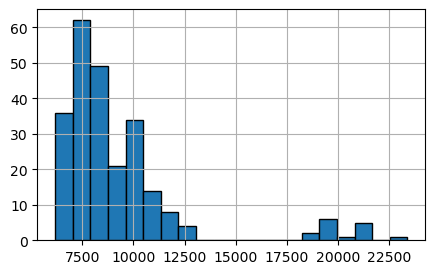

In [28]:
# 1)
## 코드작성 ##
df1=df_prep.groupby(['연도'])["분양가격"].median()
## 코드작성 끝##
df1

# 2)
## 코드작성 ##
df2=df_prep.groupby(['연도'])["분양가격"].mean()
## 코드작성 끝##
df2

# 3)
## 코드작성 ##
fig=plt.figure(figsize=(5,3))
ax1=fig.subplots()
_=df_prep.loc[df_prep['연도']==2015,'분양가격'].hist(bins=20, edgecolor='k', ax=ax1)
## 코드작성 끝##


## <실습2>
* 1) 전용면적별로 평당분양가격이 8000 이상인 데이터의 평균을 구하시오

In [38]:
print('##### 방법1 (groupby & apply)')
df1=df_prep.groupby('전용면적')['분양가격'].apply(lambda x: np.mean(x.loc[x>8000]))
df1
print('#### 방법2 (loc & groupby)')
df2=df_prep.loc[df_prep['분양가격']>8000].groupby('전용면적')['분양가격'].mean()
df2

print('#### cf) 전체데이터 사용')
df3=df_prep.groupby('전용면적')['분양가격'].mean()
df3

##### 방법1 (groupby & apply)


전용면적
102~      13641.163073
60~85     12875.832737
85~102    13202.763644
~60       12786.739888
모든면적      12901.118668
Name: 분양가격, dtype: float64

#### 방법2 (loc & groupby)


전용면적
102~      13641.163073
60~85     12875.832737
85~102    13202.763644
~60       12786.739888
모든면적      12901.118668
Name: 분양가격, dtype: float64

#### cf) 전체데이터 사용


전용면적
102~      13152.676793
60~85     11895.030518
85~102    12750.729685
~60       11859.274417
모든면적      11923.028544
Name: 분양가격, dtype: float64

## <실습3>
* 지역내의 분양가격 불균형 여부를 파악하기 위해
* 지역별로 평균(a1)대비 최대분양가격(m1)과 최소 분양가격의 차이(n1)를 구하시오: (m1-n1)/a1'

In [44]:
sr2=df_prep.groupby('지역명')['분양가격'].apply(lambda sr1: (sr1.max()-sr1.min())/sr1.mean()).sort_values()
sr2

지역명
세종    0.456527
충북    0.599310
전북    0.682830
경북    0.714563
전남    0.743640
경기    0.853218
충남    0.860557
강원    0.888407
경남    0.894296
대전    0.948174
대구    0.955084
부산    0.981250
서울    1.100706
인천    1.115499
제주    1.377654
광주    1.451115
울산    1.454671
Name: 분양가격, dtype: float64

## <실습4>
* 지역내의 분양가격 불균형 여부를 파악하기 위해
* 지역별로 평균(a1)대비 상위 top10 분양가격의 평균(m1)과 하위 top10 분양가격의 평균(n1)의 차이를 구하시오 : (m1-n1)/a1

In [46]:
def check_bias(sr1):
    sr2=sr1.sort_values(ascending=False)
    t1=sr2.head(10).mean()
    b1=sr2.tail(10).mean()
    m1=sr1.mean()
    return (t1-b1)/m1

sr3=df_prep.groupby('지역명')['분양가격'].apply(check_bias).sort_values()
sr3

지역명
세종    0.448758
충북    0.558098
전북    0.615403
전남    0.673284
경북    0.680569
경기    0.763341
충남    0.770458
인천    0.784940
강원    0.812415
대전    0.824474
경남    0.826209
대구    0.831521
부산    0.843288
서울    0.915880
광주    1.020317
울산    1.177216
제주    1.307669
Name: 분양가격, dtype: float64

지역명
세종    0.448758
충북    0.558098
전북    0.615403
전남    0.673284
경북    0.680569
경기    0.763341
충남    0.770458
인천    0.784940
강원    0.812415
대전    0.824474
경남    0.826209
대구    0.831521
부산    0.843288
서울    0.915880
광주    1.020317
울산    1.177216
제주    1.307669
Name: 분양가격, dtype: float64